# Tutorial 2: Working with Approximate Numbers

Welcome to TenSEAL's third tutorial, where we will show how to use the library for operations on encrypted real numbers. We will also present another use case for encrypted evaluations over convolutions.

This tutorial is inspired by the "Introduction to CKKS" talk at [Microsoft Private AI Bootcamp](https://www.microsoft.com/en-us/research/event/private-ai-bootcamp).

We recommend checking out the other tutorials first:
- ['Tutorial 0 - Getting Started'](https://github.com/OpenMined/TenSEAL/blob/master/tutorials/Tutorial%200%20-%20Getting%20Started.ipynb).
- ['Tutorial 1: Training and Evaluation of Logistic Regression on Encrypted Data'](https://github.com/OpenMined/TenSEAL/blob/master/tutorials/Tutorial%201%20-%20Training%20and%20Evaluation%20of%20Logistic%20Regression%20on%20Encrypted%20Data.ipynb).

Authors:
- Ayoub Benaissa - Twitter: [@y0uben11](https://twitter.com/y0uben11)
- Bogdan Cebere - Twitter: [@bcebere](https://twitter.com/bcebere)

## Introduction



TenSEAL is a library for doing homomorphic encryption operations on tensors. It's built on top of [Microsoft SEAL](https://github.com/Microsoft/SEAL), a C++ library implementing the BFV and CKKS homomorphic encryption schemes.


In this tutorial, we will briefly introduce and explain the CKKS scheme, highlighting its advantages. For more in-depth explanations, be sure to check the excellent "CKKS explained" series:

- ['Part 1, Vanilla Encoding and Decoding'](https://blog.openmined.org/ckks-explained-part-1-simple-encoding-and-decoding/).
- ['Part 2, Full Encoding and Decoding'](https://blog.openmined.org/ckks-explained-part-2-ckks-encoding-and-decoding/).
- ['Part 3, Encryption and Decryption'](https://blog.openmined.org/ckks-explained-part-3-encryption-and-decryption/).
- ['Part 4, Multiplication and Relinearization'](https://blog.openmined.org/ckks-explained-part-4-multiplication-and-relinearization/).
- ['Part 5, Rescaling'](https://blog.openmined.org/ckks-explained-part-5-rescaling/).



## Theory: CKKS scheme

__Definition__ : Cheon-Kim-Kim-Song(CKKS) is a scheme for Leveled Homomorphic Encryption that supports approximate arithmetics over complex numbers (hence, real numbers).

 
 
A high-level overview of the CKKS scheme is presented in the following diagram:

<img src="https://blog.openmined.org/content/images/2020/08/Cryptotree_diagrams-2.svg" alt="ckks-high-level" width="600"/>


## Theory: CKKS Parameters

#### The scaling factor
The first step of the CKKS scheme is encoding a vector of real numbers into a plaintext polynomial.


The scaling factor defines the encoding precision for the binary representation of the number. Intuitively, we are talking about binary precision as pictured below:



<img src="assets/floating_point.png" alt="ckks-high-level" width="400"/>

#### The polynomial modulus degree(poly_modulus_degree)

The polynomial modulus($N$ in the diagram) directly affects:
 - The number of coefficients in plaintext polynomials
 - The size of ciphertext elements
 - The computational performance of the scheme (bigger is worse)
 - The security level (bigger is better).

In TenSEAL, as in Microsoft SEAL, the degree of the polynomial modulus must be a power of 2 (e.g. $1024$, $2048$, $4096$, $8192$, $16384$, or $32768$).

#### The coefficient modulus sizes

The last parameter required for the scheme is a list of binary sizes.
Using this list, SEAL will generate a list of primes of those binary sizes, called the coefficient modulus($q$ in the diagram).

The coefficient modulus directly affects:
 - The size of ciphertext elements
 - The length of the list indicates the level of the scheme (or the number of encrypted multiplications supported).
 - The security level (bigger is worse).
 
In TenSEAL, as in Microsoft SEAL, each of the prime numbers in the coefficient modulus must be at most 60 bits and must be congruent to 1 modulo 2*poly_modulus_degree.

## Theory: CKKS Keys

#### The secret key
The secret key is used for decryption. DO NOT SHARE IT.

#### The public encryption key
The key is used for encryption in the public key encryption setup.

#### The relinearization keys
Every new ciphertext has a size of 2, and multiplying ciphertexts of sizes $K$ and $L$ results in a ciphertext of size $K+L-1$. Unfortunately, this growth in size slows down further multiplications and increases noise growth.

Relinearization is the operation that reduces the size of ciphertexts back to 2. This operation requires another type of public keys, the relinearization keys created by the secret key owner. 

The operation is needed for encrypted multiplications. The plain multiplication is fundamentally different from normal multiplication and does not result in ciphertext size growth.

#### The Galois Keys(optional)
Galois keys are another type of public keys needed to perform encrypted vector rotation operations on batched ciphertexts. 

One use case for vector rotations is summing the batched vector that is encrypted.

## Theory: CKKS internal operations
These operations are automatically executed by TenSEAL, unless the user opts-out.

#### Relinearization
The operation is executed automatically by TenSEAL after each encrypted multiplication.

The operations relinearize a ciphertext, reducing its size down to $2$. If the size of encrypted ciphertext is $K+1$, the given relinearization keys need to have a size of at least $K-1$.

#### Rescaling
The operation is executed automatically by TenSEAL after each encrypted or plain multiplication.

The approximation error exponentially grows with the number of homomorphic multiplications.
To overcome this problem, most HE schemes usually use a modulus-switching technique. In the case of CKKS, the modulus-switching procedure is called rescaling. Applying the rescaling algorithm after a homomorphic multiplication, the approximation error grows linearly, not exponentially.

Given a ciphertext encrypted modulo $q_1...q_k$, this function switches the modulus down to $q_1...q_{k-1}$ and scales the message down accordingly.

This step consumes one prime from the coefficient modulus. And when you consume all of them, you won't be able to perform more multiplications.

## Setup

All modules are imported here. Make sure everything is installed by running the cell below.

In [2]:
import torch
from torchvision import transforms
from random import randint
import pickle
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from typing import Dict

import tenseal as ts

## TenSEAL CKKS Context

The first step is to create a CKKS TenSEAL context.

One potential example is 
```
ctx = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
```
which specifies:
 - scheme type: ts.SCHEME_TYPE.CKKS
 - poly_modulus_degree: $8192$.
 - coeff_mod_bit_sizes: The coefficient modulus sizes, here [60, 40, 40, 60]. This means that the coefficient modulus will contain 4 primes of 60 bits, 40 bits, 40 bits, and 60 bits. 
 - global_scale: the scaling factor, here set to $2^{40}$.
 - optionally, TenSEAL supports switching between the public key and symmetric key encryption. By default, we will use public-key encryption.


By default, the relinearization keys are created, with automatic relinearization and rescaling enabled by default.
The user can create the Galois keys by calling generate_galois_keys.

In [3]:
def context():
    context = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
    context.global_scale = pow(2, 40)
    context.generate_galois_keys()
    return context

context = context()

## Plain tensor creation

PlainTensor class works as a translation layer from common tensor representations to the encrypted forms offered by TenSEAL. It is the first step required for creating an encrypted tensor using TenSEAL.

Observation: This translation is also automatically done by the encrypted tensor constructors, and you can skip it.

<img src="assets/plaintensor_indepth.png" align="center" style="display: block;  margin: auto;" />


In [4]:
plain1 = ts.plain_tensor([1,2,3,4], [2,2])

print(" First tensor: Shape = {} Data = {}".format(plain1.shape, plain1.tolist()))

plain2 = ts.plain_tensor(np.array([5,6,7,8]).reshape(2,2))
print(" Second tensor: Shape = {} Data = {}".format(plain2.shape, plain2.tolist()))

 First tensor: Shape = [2, 2] Data = [[1.0, 2.0], [3.0, 4.0]]
 Second tensor: Shape = [2, 2] Data = [[5.0, 6.0], [7.0, 8.0]]


## Theory: Encrypted tensor creation

CKKS requires two operations for encrypting a new message:

### CKKS Encoding and Decoding
The operation encodes vectors of complex or real numbers into plaintext polynomials to be encrypted and computed using the CKKS scheme.

If the polynomial modulus degree is $N$, then the encoding converts vectors of N/2 complex numbers into plaintext elements. Homomorphic operations performed on such encrypted vectors are applied coefficient (slot-)wise, enabling powerful SIMD functionality for computations that are vectorizable. (also known as batching)


The following diagram shows the detailed encoding-decoding flow(credits to [Yongsoo Song, Introduction to CKKS, [Microsoft Private AI Bootcamp]](https://www.youtube.com/watch?v=iQlgeL64vfo))

<img src="assets/ckks_encoding.png" alt="ckks-high-level" width="600"/>

### CKKS Encryption and Decryption
This operation converts a plaintext polynomial to a ciphertext.


The following diagram shows the detailed encryption-decryption flow(credits to [Yongsoo Song, Introduction to CKKS, [Microsoft Private AI Bootcamp]](https://www.youtube.com/watch?v=iQlgeL64vfo)))

<img src="assets/ckks_encryption.png" alt="ckks-high-level" width="600"/>

## Practice: Encrypted tensor creation

For creating a new encrypted tensor, TenSEAL executes the encoding and encryption automatically.
This applies to both CKKS and BFV schemes.

The encrypted tensor encrypts a PlainTensor and stores the ciphertexts and shapes internally.

We have a few variants of encrypted tensors:
 - **BFVVector** - for 1D integer arrays.
 - **CKKSVector** - for 1D float arrays. This version has a smaller memory footprint, but it is less flexible.
 - **CKKSTensor** - for N-dimensional float arrays. This version supports tensorial operations on encrypted data, like reshaping or broadcasting.
 
 
<img src="assets/encrypted_tensor_relation.png" align="center" style="display: block;  margin: auto;" />

In [5]:
encrypted_tensor1 = ts.ckks_tensor(context, plain1)
encrypted_tensor2 = ts.ckks_tensor(context, plain2)

print(" Shape = {}".format(encrypted_tensor1.shape))
print(" Encrypted Data = {}.".format(encrypted_tensor1))


encrypted_tensor_from_np = ts.ckks_tensor(context, np.array([5,6,7,8]).reshape([2,2]))
print(" Shape = {}".format(encrypted_tensor_from_np.shape))

 Shape = [2, 2]
 Encrypted Data = <tenseal.tensors.ckkstensor.CKKSTensor object at 0x6ffb97103f70>.
 Shape = [2, 2]


## Basic operations

The following table enumerates the operations supported by CKKS tensors variants.

| Operation                    | Description                                                   |
| --- | --- |
| negate                       | Negate an encrypted tensor                                    |
| square                       | Compute the square of an encrypted tensor                     |
| power                        | Compute the power of an encrypted tensor                      |
| add                          | Addition between two encrypted tensors                        |
| add\_plain                   | Addition between an encrypted tensor and a plain tensor       |
| sub                          | Subtraction between two encrypted tensors                     |
| sub\_plain                   | Subtraction between an encrypted tensor and a plain tensor    |
| mul                          | Multiplication between two encrypted tensors                  |
| mul\_plain                   | Multiplication between an encrypted tensor and a plain tensor |
| dot                 | Dot product between two encrypted tensors                     |
| dot\_plain          | Dot product between an encrypted tensor and a plain tensor    |
| polyval                      | Polynomial evaluation with an encrypted tensor as variable    |
| matmul                | Multiplication between an encrypted vector and a plain matrix |
| matmul\_plain           | Encrypted matrix multiplication with plain vector             |


The CKKSVector variant contains the following additional operations:


| Operation                    | Description                                                   |
| --- | --- |
| conv2d\_im2col               | Image Block to Columns                                        |


In [6]:
def decrypt(enc):
    return enc.decrypt().tolist()

### Addition of two encrypted tensors.

In [22]:
result = encrypted_tensor1 + encrypted_tensor2
print("Plain equivalent: {} + {}\nDecrypted result: {}.".format(plain1.tolist(), plain2.tolist(), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] + [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[6.000000000193637, 7.999999999783835], [10.000000000207743, 12.000000000762785]].


### Subtraction of two encrypted tensors.

In [8]:
result = encrypted_tensor1 - encrypted_tensor2
print("Plain equivalent: {} - {}\nDecrypted result: {}.".format(plain1.tolist(), plain2.tolist(), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] - [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[-4.000000001950126, -3.9999999998558478], [-4.000000000126492, -4.000000000223727]].


### Multiplication of two encrypted tensors. 

The following diagram shows the detailed flow for multiplication and relinearization (credits to [Yongsoo Song, Introduction to CKKS, [Microsoft Private AI Bootcamp]](https://www.youtube.com/watch?v=iQlgeL64vfo)))


<img src="assets/ckks_mul.png" alt="ckks-high-level" width="600"/>

In [9]:
result = encrypted_tensor1 * encrypted_tensor2
print("Plain equivalent: {} * {}\nDecrypted result: {}.".format(plain1.tolist(), plain2.tolist(), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] * [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[5.000000667173633, 12.000001609284796], [21.000002816785745, 32.00000429616898]].


### Multiplication with plain tensor

In [10]:
plain = ts.plain_tensor([5,6,7,8], [2,2])
result = encrypted_tensor1 * plain

print("Plain equivalent: {} * {}\nDecrypted result: {}.".format(plain1.tolist(), plain.tolist(), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] * [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[5.000000667438727, 12.00000160926727], [21.000002817031387, 32.00000429306026]].


### Negation

In [11]:
result = -encrypted_tensor1 

print("Plain equivalent: -{}\nDecrypted result: {}.".format(plain1.tolist(), decrypt(result)))

Plain equivalent: -[[1.0, 2.0], [3.0, 4.0]]
Decrypted result: [[-0.9999999991217557, -1.9999999999639946], [-3.0000000000406257, -4.00000000026953]].


### Power

In [12]:
result = encrypted_tensor1 ** 3
print("Plain equivalent: {} ^ 3\nDecrypted result: {}.".format(plain1.tolist(), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] ^ 3
Decrypted result: [[1.0000008016514972, 8.00000644158613], [27.000021722163964, 64.00005151211694]].


### Polynomial evaluation $1 + X^2 + X^3$

In [13]:
result = encrypted_tensor1.polyval([1,0,1,1])

print("X = {}".format(plain1.tolist()))
print("1 + X^2 + X^3 = {}.".format(decrypt(result)))

X = [[1.0, 2.0], [3.0, 4.0]]
1 + X^2 + X^3 = [[3.000000934657128, 13.000006980971383], [37.00002292683481, 81.00005366061046]].


### Sigmoid approximation
$\sigma(x) = 0.5 + 0.197 x - 0.004 x^3$

Reference: ["Logistic regression over encrypted data from fully homomorphic encryption", Hao Chen et al](https://eprint.iacr.org/2018/462.pdf)

In [14]:
result = encrypted_tensor1.polyval([0.5, 0.197, 0, -0.004])


print("X = {}".format(plain1.tolist()))
print("0.5 + 0.197 X - 0.004 x^X = {}.".format(decrypt(result)))


X = [[1.0, 2.0], [3.0, 4.0]]
0.5 + 0.197 X - 0.004 x^X = [[0.6930000206536739, 0.8620000236358913], [0.9829999785378186, 1.0319998472693994]].


# Encrypted inference demo

Now that we introduced the CKKS scheme let's see it in action.

The next example contains a classification over the MNIST dataset using a single convolution and two fully connected layers with a square activation function.

It illustrates one of the prominent use cases for homomorphic encryption, as depicted here.

<img src="https://blog.openmined.org/content/images/2020/04/OM---CKKS-Graphic-v.01@2x.png" align="center" style="display: block;  margin: auto;"/>


Adapted from https://github.com/youben11/encrypted-evaluation

## Client Helpers

In [15]:
# Create the TenSEAL security context
def create_ctx():
    """Helper for creating the CKKS context.
    CKKS params:
        - Polynomial degree: 8192.
        - Coefficient modulus size: [40, 21, 21, 21, 21, 21, 21, 40].
        - Scale: 2 ** 21.
        - The setup requires the Galois keys for evaluating the convolutions.
    """
    poly_mod_degree = 8192
    coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
    ctx = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    ctx.global_scale = 2 ** 21
    ctx.generate_galois_keys()
    return ctx

# Sample an image
def load_input():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )
    idx = randint(1, 6)
    img_name = "data/mnist-samples/img_{}.jpg".format(idx)
    print(img_name)
    img = Image.open(img_name)
    return transform(img).view(28, 28).tolist(), img

# Helper for encoding the image
def prepare_input(ctx, plain_input):
    enc_input, windows_nb = ts.im2col_encoding(ctx, plain_input, 7, 7, 3)
    assert windows_nb == 64
    return enc_input

## Server Model

 - We are using a pretrained plain model, stored in "tutorials/parameters/ConvMNIST-0.1.pickle".

In [16]:
# Load a pretrained model and adapt the forward call for encrypted input
class ConvMNIST():
    """CNN for classifying MNIST data.
    Input should be an encoded 28x28 matrix representing the image.
    TenSEAL can be used for encoding `tenseal.im2col_encoding(ctx, input_matrix, 7, 7, 3)`
    The input should also be normalized with a mean=0.1307 and an std=0.3081 before encryption.
    """

    def __init__(self, parameters: Dict[str, list]):
        self.conv1_weight = parameters["conv1_weight"]
        self.conv1_bias = parameters["conv1_bias"]
        self.fc1_weight = parameters["fc1_weight"]
        self.fc1_bias = parameters["fc1_bias"]
        self.fc2_weight = parameters["fc2_weight"]
        self.fc2_bias = parameters["fc2_bias"]
        self.windows_nb = parameters["windows_nb"]

    def forward(self, enc_x: ts.CKKSVector) -> ts.CKKSVector:
        # conv layer
        channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, self.windows_nb) + bias
            channels.append(y)
        out = ts.CKKSVector.pack_vectors(channels)
        # squaring
        out.square_()
        # no need to flat
        # fc1 layer
        out = out.mm_(self.fc1_weight) + self.fc1_bias
        # squaring
        out.square_()
        # output layer
        out = out.mm_(self.fc2_weight) + self.fc2_bias
        return out

    @staticmethod
    def prepare_input(context: bytes, ckks_vector: bytes) -> ts.CKKSVector:
        try:
            ctx = ts.context_from(context)
            enc_x = ts.ckks_vector_from(ctx, ckks_vector)
        except:
            raise DeserializationError("cannot deserialize context or ckks_vector")
        try:
            _ = ctx.galois_keys()
        except:
            raise InvalidContext("the context doesn't hold galois keys")

        return enc_x
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

## Server helpers

In [17]:
import pickle
import os

def load_parameters(file_path: str) -> dict:
    try:
        parameters = pickle.load(open(file_path, "rb"))
        print(f"Model loaded from '{file_path}'")
    except OSError as ose:
        print("error", ose)
        raise ose
    return parameters



parameters = load_parameters("parameters/ConvMNIST-0.1.pickle")
model = ConvMNIST(parameters)

Model loaded from 'parameters/ConvMNIST-0.1.pickle'


## Client Query
The client has to create the CKKS context for the first query.
Then, he samples and encrypts a random image from the dataset.

The serialized context and encrypted image are sent to the server for evaluation.

data/mnist-samples/img_5.jpg
Encrypted image  <tenseal.tensors.ckksvector.CKKSVector object at 0x6ffca02bceb0>
Original image 


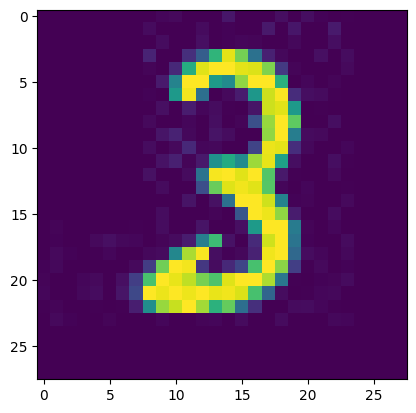

In [18]:
# CKKS context generation.
context = create_ctx()

# Random image sampling
image, orig = load_input()

# Image encoding
encrypted_image = prepare_input(context, image)

print("Encrypted image ", encrypted_image)
print("Original image ")
imshow(np.asarray(orig))

# We prepare the context for the server, by making it public(we drop the secret key)
server_context = context.copy()
server_context.make_context_public()

# Context and ciphertext serialization
server_context = server_context.serialize()
encrypted_image = encrypted_image.serialize()


client_query = {
    "data" : encrypted_image,
    "context" : server_context,
}

## Server inference

The server deserializes the context and ciphertext.
It executes the inference, serializes the result and sends it back to the client.

In [19]:
encrypted_query = model.prepare_input(client_query["context"], client_query["data"])
encrypted_result = model(encrypted_query).serialize()

server_response = {
    "data" : encrypted_result
}

## Client process response

The client deserializes and decrypts the result.
Since we cannot run the non-linearity over the CKKSVector, we run the last softmax step on the client side.

Finally, we retrieve the final result.

In [20]:
result = ts.ckks_vector_from(context, server_response["data"]).decrypt()

probs = torch.softmax(torch.tensor(result), 0)
label_max = torch.argmax(probs)
print("Maximum probability for label {}".format(label_max))

Maximum probability for label 3


# Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement towards privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!

### Star TenSEAL on GitHub

The easiest way to help our community is just by starring the Repos! This helps raise awareness of the cool tools we're building.

- [Star TenSEAL](https://github.com/OpenMined/TenSEAL)

### Join our Slack!

The best way to keep up to date on the latest advancements is to join our community! You can do so by filling out the form at [http://slack.openmined.org](http://slack.openmined.org).

### Donate

If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

[OpenMined's Open Collective Page](https://opencollective.com/openmined)

## References

1. Yongsoo Song, Introduction to CKKS, [Private AI Bootcamp](microsoft.com/en-us/research/event/private-ai-bootcamp/#!videos).
2. [Microsoft SEAL](https://github.com/microsoft/SEAL).
3. Daniel Huynh, [CKKS Explained Series](https://blog.openmined.org/ckks-explained-part-1-simple-encoding-and-decoding/).